In [6]:
# Install necessary libraries (run in Jupyter cell or terminal)
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
    

In [7]:
#load 

import pandas as pd
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)

df.head()
df.info()
df.describe()


C:\Users\staru\AppData\Local\Temp\ipykernel_64944\1507445258.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\staru\AppData\Local\Temp\ipykernel_64944\1507445258.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\staru\AppData\Local\Temp\ipykernel_64944\1507445258.py:4: UserWarning: Parsing dates in %d/%m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-06 07:12:59.999994112,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:18:30,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-12-06 07:13:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-12-01 14:07:30,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00


In [8]:
# clean data 

import pandas as pd

# Load data with datetime parsing
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False
)

# Set Datetime as the index
df.set_index('Datetime', inplace=True)

# Resample to hourly averages
df_hourly = df.resample('h').mean()

df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = df_hourly['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


C:\Users\staru\AppData\Local\Temp\ipykernel_64944\2680803336.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\staru\AppData\Local\Temp\ipykernel_64944\2680803336.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\staru\AppData\Local\Temp\ipykernel_64944\2680803336.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


In [10]:
# Lag features
df_hourly['lag_1'] = df_hourly['Global_active_power'].shift(1)
df_hourly['lag_24'] = df_hourly['Global_active_power'].shift(24)

# Rolling means
df_hourly['rolling_3h'] = df_hourly['Global_active_power'].rolling(window=3).mean()
df_hourly['rolling_24h'] = df_hourly['Global_active_power'].rolling(window=24).mean()

# Drop NA from new features
df_hourly.dropna(inplace=True)

# Select features and target
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_24', 'rolling_3h', 'rolling_24h']
X = df_hourly[features]
y = df_hourly['Global_active_power']


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# Display results
pd.DataFrame(results).T.sort_values('RMSE')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 27142, number of used features: 8
[LightGBM] [Info] Start training from score 1.109582


c:\Users\staru\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,RMSE,MAE,R2
LightGBM,0.336683,0.226845,0.795948
XGBoost,0.341817,0.228276,0.789678
Random Forest,0.345607,0.227325,0.784987
Linear Regression,0.396664,0.284131,0.716767


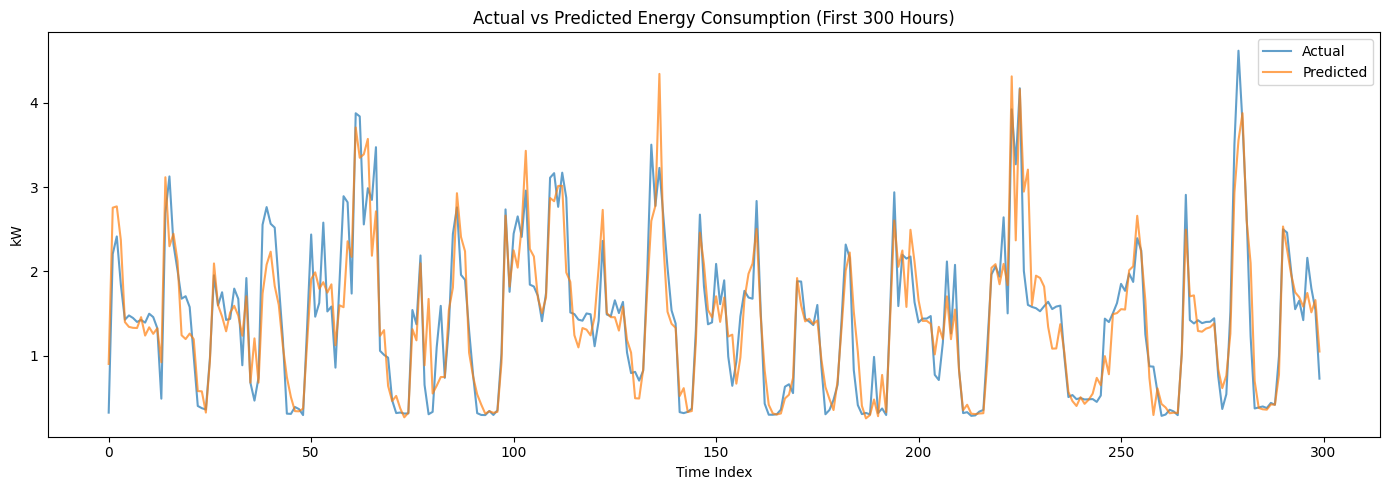

In [12]:
# Plot actual vs predicted for best model (e.g., XGBoost)
best_model = models['XGBoost']
y_pred = best_model.predict(X_test_scaled)
plt.figure(figsize=(14,5))
plt.plot(y_test.values[:300], label='Actual', alpha=0.7)
plt.plot(y_pred[:300], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Energy Consumption (First 300 Hours)')
plt.xlabel('Time Index')
plt.ylabel('kW')
plt.legend()
plt.tight_layout()
plt.show()



In [2]:
import pandas as pd

# Step 1: Load the raw dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Step 2: Convert relevant columns to float
cols_to_convert = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

df[cols_to_convert] = df[cols_to_convert].astype(float)

# Step 3: Set Datetime as the index
df.set_index('Datetime', inplace=True)

# Step 4: Resample data to hourly frequency and create time-based features
df_hourly = df.resample('h').mean()

df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = df_hourly['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Check if it's a weekend
df_hourly['lag_1'] = df_hourly['Global_active_power'].shift(1)
df_hourly['lag_24'] = df_hourly['Global_active_power'].shift(24)
df_hourly['rolling_3h'] = df_hourly['Global_active_power'].rolling(window=3).mean()
df_hourly['rolling_24h'] = df_hourly['Global_active_power'].rolling(window=24).mean()

# Drop NA from new features
df_hourly.dropna(inplace=True)

# Step 5: Save cleaned hourly data to CSV
df_hourly.to_csv('cleaned_data.csv')

print("Preprocessing complete! The file 'cleaned_hourly.csv' is saved.")


C:\Users\staru\AppData\Local\Temp\ipykernel_64328\3088498513.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\staru\AppData\Local\Temp\ipykernel_64328\3088498513.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?', parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)
C:\Users\staru\AppData\Local\Temp\ipykernel_64328\3088498513.py:4: UserWarning: Parsing dates in %d/%m

Preprocessing complete! The file 'cleaned_hourly.csv' is saved.
